In [ ]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from tqdm import tqdm
import os
from joblib import dump, load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Intersect all Healthy Data Files to find common gene_ids
import os

# Define the path to the folder containing TSV files
folder_path = '/content/drive/MyDrive/Datasets/encode_healthy'

# Get a list of all TSV files in the folder
tsv_files = [file for file in os.listdir(folder_path) if file.endswith('.tsv')]

healthy_common_gene_ids = None

for tsv_file in tsv_files:
    file_path = os.path.join(folder_path, tsv_file)

    ddf = df.read_csv(file_path, delimiter='\t', dtype={'gene_id': 'object'}, blocksize=1e6)

    # Check if 'gene_id' column exists in the DataFrame
    if 'gene_id' in ddf.columns:
        # Get the unique values in the 'gene_id' column
        unique_gene_ids = set(ddf['gene_id'].compute())

        if healthy_common_gene_ids is None:
            healthy_common_gene_ids = unique_gene_ids
        else:
            healthy_common_gene_ids.intersection_update(unique_gene_ids)


    ddf = None

In [ ]:
# Intersect all Cancer Data Files to find common gene_ids
main_folder_path = '/content/drive/MyDrive/Datasets/gdc_cancer/lung_cancer'

cancer_common_gene_ids = None

# Iterate through each sub-folder
for sub_folder in os.listdir(main_folder_path):
    sub_folder_path = os.path.join(main_folder_path, sub_folder)

    if os.path.isdir(sub_folder_path):
        # Get a list of TSV files in the sub-folder
        tsv_files = [file for file in os.listdir(sub_folder_path) if file.endswith('.tsv')]

        # Iterate through each TSV file in the sub-folder
        for tsv_file in tsv_files:
            file_path = os.path.join(sub_folder_path, tsv_file)

            # Read the TSV file using Dask and specify dtype for 'gene_id'
            # I skip row 0 here because it's the line about gene model
            ddf = df.read_csv(file_path, delimiter='\t', skiprows=[0], dtype={'gene_id': 'object'})

            # Check if 'gene_id' column exists in the DataFrame
            if 'gene_id' in ddf.columns:
                # Get the unique values in the 'gene_id' column
                unique_gene_ids = set(ddf['gene_id'].compute())

                if cancer_common_gene_ids is None:
                    cancer_common_gene_ids = unique_gene_ids
                else:
                    cancer_common_gene_ids.intersection_update(unique_gene_ids)

In [ ]:
# Get intersection between healthy and cancer gene_ids
common_genes_set = healthy_common_gene_ids & cancer_common_gene_ids
common_genes_list = list(common_genes_set)

In [ ]:
# Create Cancer Dataframe
main_folder_path = '/content/drive/MyDrive/Datasets/gdc_cancer/lung_cancer'

count = 0
list_dfs = []

# Iterate through each sub-folder
for sub_folder in tqdm(os.listdir(main_folder_path)):
    sub_folder_path = os.path.join(main_folder_path, sub_folder)

    if os.path.isdir(sub_folder_path):
        # Get a list of TSV files in the sub-folder
        tsv_files = [file for file in os.listdir(sub_folder_path) if file.endswith('.tsv')]

        # Iterate through each TSV file in the sub-folder
        for tsv_file in tsv_files:
            file_path = os.path.join(sub_folder_path, tsv_file)

            # Read the TSV file as Dask dataframe
            df = dd.read_csv(file_path, sep='\t', header=1)
            df = df.loc[4:]
            # select only required columns and reset index:
            df = df[['gene_id', 'tpm_unstranded']].reset_index(drop=True)
            # Filter for common genes only:
            df = df[df['gene_id'].isin(common_genes_list)]
            # assign an index which will then become row name after pivoting:
            df = df.assign(index = count)
            count = count + 1 # increment counter
            # categorize the 'gene_id' col in pivot table
            df = df.categorize(columns=['gene_id'])
            # pivot data:
            pivot_df = df.pivot_table(index = 'index', columns='gene_id')
            # pivot_df.columns = pivot_df.columns.drop_level(0)
            pivot_df = pivot_df.reset_index()
            # append dataframe to list:
            list_dfs.append(pivot_df)

In [ ]:
result = dd.concat(list_dfs, axis=0, join='outer')

# add target column:
result['cancer'] = 1

# save as parquet
result.to_parquet('/content/drive/MyDrive/Datasets/cancer_data_pivoted')

In [ ]:
# Create the Healthy Dataframe
main_folder_path = '/content/drive/MyDrive/Datasets/encode_healthy'

# Get a list of all TSV files in the folder
tsv_files = [file for file in os.listdir(main_folder_path) if file.endswith('.tsv')]

count = 600
list_dfs = []

for tsv_file in tqdm(tsv_files):
    file_path = os.path.join(main_folder_path, tsv_file)

    # Read the TSV file as Dask dataframe
    df = dd.read_csv(file_path, sep='\t', header=0, dtype={'gene_id': 'object'})

    if 'gene_id' in df.columns:
        # select only required columns and reset index:
        df = df[['gene_id', 'TPM']].reset_index(drop=True)
        # group by gene ID and aggregate sum of mRNA count:
        df = df.groupby('gene_id').agg('sum').reset_index()
        # Filter for common genes only:
        df = df[df['gene_id'].isin(common_genes_list)]
        # assign an index which will then become row name after pivoting:
        df = df.assign(index = count)
        count = count + 1 # increment counter
        # categorize the 'gene_id' col in pivot table
        df = df.categorize(columns=['gene_id'])
        # pivot data:
        pivot_df = df.pivot_table(index = 'index', columns='gene_id')
        pivot_df = pivot_df.reset_index()
        # append dataframe to list:
        list_dfs.append(pivot_df)

In [ ]:
result = dd.concat(list_dfs, axis=0, join='outer')

# add target column:
result['cancer'] = 0

# save as parquet
result.to_parquet('/content/drive/MyDrive/Datasets/healthy_data_pivoted')

In [ ]:
cancer_load = dd.read_parquet('/content/drive/MyDrive/Datasets/cancer_data_pivoted')
cancer_load.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 26132 entries, index to cancer
dtypes: float64(26130), int64(2)

In [ ]:
print(cancer_load.dtypes)

index                  int64
ENSG00000019995.6    float64
ENSG00000039139.9    float64
ENSG00000053328.8    float64
ENSG00000060303.5    float64
                      ...   
ENSG00000273486.1    float64
ENSG00000273487.1    float64
ENSG00000273489.1    float64
ENSG00000273493.1    float64
cancer                 int64
Length: 26132, dtype: object


In [ ]:
healthy_load = dd.read_parquet('/content/drive/MyDrive/Datasets/healthy_data_pivoted')
healthy_load.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 26132 entries, index to cancer
dtypes: float64(26130), int64(2)

In [ ]:
print(healthy_load.dtypes)

index                  int64
ENSG00000019995.6    float64
ENSG00000039139.9    float64
ENSG00000053328.8    float64
ENSG00000060303.5    float64
                      ...   
ENSG00000273486.1    float64
ENSG00000273487.1    float64
ENSG00000273489.1    float64
ENSG00000273493.1    float64
cancer                 int64
Length: 26132, dtype: object


In [ ]:
big_table = dd.concat([cancer_load, healthy_load], axis=0, join='inner')

In [ ]:
big_table.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 26132 entries, index to cancer
dtypes: float64(26130), int64(2)

In [ ]:
print(big_table.dtypes)

index                  int64
ENSG00000019995.6    float64
ENSG00000039139.9    float64
ENSG00000053328.8    float64
ENSG00000060303.5    float64
                      ...   
ENSG00000273486.1    float64
ENSG00000273487.1    float64
ENSG00000273489.1    float64
ENSG00000273493.1    float64
cancer                 int64
Length: 26132, dtype: object


In [ ]:
# Feature importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# Dask
from dask.distributed import Client
# import dask.dataframe as dd
import joblib

# Create Local Dask Client
client = Client(processes=False)

In [ ]:
target = big_table[['cancer']]

In [ ]:
target.info()

In [ ]:
columns_to_exclude = ['index', 'cancer']

# Exclude the specified columns
just_features = big_table.drop(columns=columns_to_exclude)

In [ ]:
just_features.info()

In [ ]:
# Fit an Extra Trees Model
model = ExtraTreesClassifier()

# When fitting, use dask joblib backend
with joblib.parallel_backend('dask'):
  model.fit(just_features, target)

In [ ]:
# Display the relative importance of eacdh attribute
model = load("/content/drive/MyDrive/feature_selection.joblib")
print(len(model.feature_importances_))

In [ ]:
# import numpy as np

# importances = model.feature_importances_

# # Specify the file path for the CSV file
# csv_file_path = 'list_importances.csv'

# # Export the NumPy array as a CSV file
# np.savetxt(csv_file_path, importances, delimiter=',', fmt='%.10f')

importances = np.loadtxt("/content/drive/MyDrive/list_importances.xls",
                 delimiter=",")

In [ ]:
import heapq

k = 10
k_keys_sorted = heapq.nlargest(k, importances)
print(k_keys_sorted)

[0.0158049666, 0.0122457745, 0.0119014711, 0.0104233614, 0.0098487612, 0.0096353419, 0.0095142518, 0.0094183488, 0.0093738742, 0.0091918626]


In [ ]:
importance_count = 0
for i in importances:
    if i > 0:
        importance_count += 1

print(importance_count)

759


In [ ]:
# from joblib import dump, load
# dump(model, "feature_selection.joblib")
# Load with x = load("feature_selection.joblib")

In [ ]:
# Repartition Dataframe
total_data = big_table.repartition(npartitions=20)

In [ ]:
total_data.head(5)

In [ ]:
# Slice out only the important features (Already Done)
features = total_data.columns[1:-1]
feature_array = []
# Iterate through features and importances by index and keep new ones in an array to slice the dataframe after
for i in range (0, len(features)):
    if importances[i] > 0:
        feature_array.append(features[i])
important_data = total_data[['index'] + feature_array + ['cancer']]
# important_data.info()
# Save to Parquet Here
important_data.to_parquet("Documents/Big Data/important_parquet/important_data_save")

In [ ]:
# Train Test Split
final_data = dd.read_parquet("/content/drive/MyDrive/Datasets/important_data_save")
train, test = final_data.random_split([0.8, 0.2])

In [ ]:
# Make Feature Array For Later
features = final_data.columns[1:-1]
full_feature_array = []
# Iterate through features and importances by index and keep new ones in an array to slice the dataframe after
for i in range (0, len(features)):
    full_feature_array.append(features[i])

In [ ]:
# Ensure the split was mostly even number from each class
train_cancer = 0
train_healthy = 0
for r in tqdm(train['cancer']):
    if r > 0:
        train_cancer += 1
    else:
        train_healthy += 1
print("Train Cancer: " + str(train_cancer) + "     Train Healthy: " + str(train_healthy))

NameError: ignored

In [ ]:
# Part 2
test_cancer = 0
test_healthy = 0
for t in tqdm(test['cancer']):
    if t > 0:
        test_cancer += 1
    else:
        test_healthy += 1
print("Test Cancer: " + str(test_cancer) + "     Test Healthy: " + str(test_healthy))

100%|██████████| 226/226 [00:00<00:00, 277.02it/s]

Test Cancer: 115     Test Healthy: 111


In [ ]:
# Filter out index and cancer columns and save dask array for cancer column
train_y = train[['cancer']].to_dask_array().compute()
columns_to_exclude = ['index', 'cancer']

# Exclude the specified columns
final_features = train.drop(columns=columns_to_exclude)

In [ ]:
# Perform ML with Decision Tree Classifier with max_depth of 5
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Dask
from dask.distributed import Client
# import dask.dataframe as dd
import joblib

# Create Local Dask Client
client = Client(processes=False)

# Fit an Decision Tree Model
final_tree = DecisionTreeClassifier()

# When fitting, use dask joblib backend
with joblib.parallel_backend('dask'):
  final_tree.fit(final_features, train_y)

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45257 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/4138/28
INFO:distributed.scheduler:  dashboard at:  http://172.28.0.12:45257/status
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/4138/31
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:33947
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/4138/28
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          2
INFO:distributed.worker:               Memory:                  12.67 GiB
INF

[Text(0.5, 0.75, 'ENSG00000236675.1 <= 0.559\ngini = 0.499\nsamples = 831\nvalue = [399, 432]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 399\nvalue = [399, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 432\nvalue = [0, 432]')]

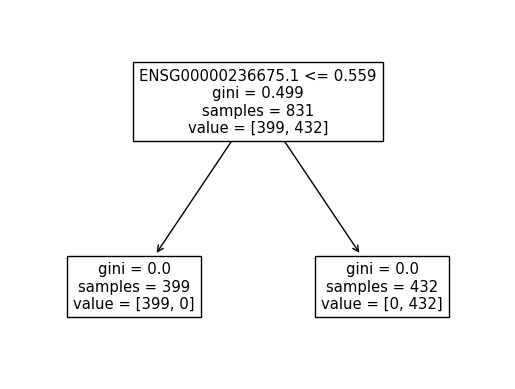

In [ ]:
# Show new importance and tree
tree.plot_tree(final_tree, feature_names=full_feature_array)

In [ ]:
# Filter out index and cancer columns and save dask array for test data
test_y = test[['cancer']].to_dask_array().compute()
columns_to_exclude = ['index', 'cancer']

# Exclude the specified columns
test_features = test.drop(columns=columns_to_exclude)

# Predict and Compare to Test Set
pred_y = final_tree.predict(test_features)

KeyboardInterrupt: ignored

In [ ]:
correct = 0
for i in range(0, len(pred_y)):
    if pred_y[i] == test_y[i][0]:
        correct += 1
    else:
        print("Predicted was: " + str(pred_y[i]) + " and Test was: " + str(test_y[i]))

accuracy = correct/len(pred_y)
print("The predictive accuracy is: " + str(100 * accuracy) + "%")

Predicted was: 1 and Test was: [0]
Predicted was: 1 and Test was: [0]
The predictive accuracy is: 99.11504424778761%


In [ ]:
# Perform ML with Random Forest Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Dask
from dask.distributed import Client
# import dask.dataframe as dd
import joblib

# Create Local Dask Client
client = Client(processes=False)

# Fit an Decision Tree Model
forest_model = RandomForestClassifier()

# When fitting, use dask joblib backend
with joblib.parallel_backend('dask'):
  forest_model.fit(final_features, train_y.ravel())

C:\Users\andre\anaconda3\envs\gpu_env\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64236 instead
  warnings.warn(


In [ ]:
# Filter out index and cancer columns and save dask array for test data
test_y_2 = test[['cancer']].to_dask_array().compute()
columns_to_exclude = ['index', 'cancer']

# Exclude the specified columns
test_features_2 = test.drop(columns=columns_to_exclude)

# Predict and Compare to Test Set
pred_y_2 = forest_model.predict(test_features_2)

In [ ]:
correct = 0
for i in range(0, len(pred_y_2)):
    if pred_y_2[i] == test_y[i][0]:
        correct += 1
    else:
        print("Predicted was: " + str(pred_y_2[i]) + " and Test was: " + str(test_y[i]))

accuracy = correct/len(pred_y)
print("The predictive accuracy is: " + str(100 * accuracy) + "%")

The predictive accuracy is: 100.0%


In [ ]:
print(forest_model.feature_importances_)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.14201672e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e-02
 1.44391096e-04 0.00000000e+00 2.00000000e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.84725576e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.00000000e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.85560890e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [ ]:
import heapq

forest_importances = forest_model.feature_importances_
k = 7
k_keys_sorted = heapq.nlargest(k, forest_importances)
# print(k_keys_sorted)
index_list = []
for j in range(0, len(forest_importances)):
    if forest_importances[j] in k_keys_sorted:
        index_list.append(j)
print(index_list)

[11, 68, 130, 476, 487, 506, 666]


In [ ]:
gene_list = []
for idx in index_list:
    gene_list.append(full_feature_array[idx])

print(gene_list)

['ENSG00000136149.6', 'ENSG00000203362.2', 'ENSG00000215006.4', 'ENSG00000253797.2', 'ENSG00000254612.2', 'ENSG00000256393.1', 'ENSG00000268030.1']
